In [1]:
import tensorflow as tf
import os
import sys
add_dir = os.path.abspath('./data/')
sys.path.append(add_dir)
import tf_extended as tfe
import numpy as np
import cv2
import tensorflow.contrib.slim as slim
from tensorflow.python.ops import random_ops,control_flow_ops
from tensorflow.python.keras.initializers import he_normal
import math
import random
from data import ssd_common
from data import loss_function
from matplotlib import pyplot as plt
from data import custom_layers
from data import np_methods

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.app.flags.DEFINE_integer('image_size', 300, "Needs to provide same value as in training.")
tf.app.flags.DEFINE_integer('num_class', 21, "Actual num of class +1.")
tf.app.flags.DEFINE_string('log_dir','./SSD_Billy/log','tensorboard directory')
tf.app.flags.DEFINE_string('checkpoint_dir','./SSD_Billy/checkpoint/','The directory where to save the parameters of the network')
FLAGS = tf.app.flags.FLAGS
tf.app.flags.DEFINE_string('f', '', 'kernel')

In [3]:
def fully_connected(prev_layer, num_units, is_training=False):
    layer = tf.layers.dense(prev_layer, num_units, use_bias=True, activation=None)
    layer = tf.layers.batch_normalization(layer, training=is_training)
    layer = tf.nn.relu(layer)
    return layer

In [4]:
def conv_layer_conv(prev_layer, layer_depth, is_training=False):
    conv_layer1 = tf.layers.conv2d(prev_layer, layer_depth, [3,3], 1, 'same', use_bias=True,kernel_initializer=he_normal(seed=0.01),activation=None,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
    conv_layer1_bn = tf.layers.batch_normalization(conv_layer1, training=is_training)
    conv_layer1_out = tf.nn.relu(conv_layer1_bn)

    pool_layer1 = tf.layers.max_pooling2d(conv_layer1_out,[2,2],strides=2,padding='same')
    return pool_layer1

In [5]:
def conv_layer_2conv(prev_layer, layer_depth, is_training=False):
    conv_layer1 = tf.layers.conv2d(prev_layer, layer_depth, [3,3], 1, 'same', use_bias=True,kernel_initializer=he_normal(seed=0.01),activation=None,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
    conv_layer1_bn = tf.layers.batch_normalization(conv_layer1, training=is_training)
    conv_layer1_out = tf.nn.relu(conv_layer1_bn)
    
    conv_layer2 = tf.layers.conv2d(conv_layer1_out, layer_depth, [3,3], 1, 'same', use_bias=True,kernel_initializer=he_normal(seed=0.01),activation=None,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
    conv_layer2_bn = tf.layers.batch_normalization(conv_layer2, training=is_training)
    conv_layer2_out = tf.nn.relu(conv_layer2_bn)

    pool_layer2 = tf.layers.max_pooling2d(conv_layer2_out,[2,2],strides=2,padding='same')
    return pool_layer2,conv_layer2_out

In [6]:
def conv_layer_3conv(prev_layer, layer_depth, is_training=False):
    conv_layer1 = tf.layers.conv2d(prev_layer, layer_depth, [3,3], 1, 'same', use_bias=True,kernel_initializer=he_normal(seed=0.01),activation=None,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
    conv_layer1_bn = tf.layers.batch_normalization(conv_layer1, training=is_training)
    conv_layer1_out = tf.nn.relu(conv_layer1_bn)
    
    conv_layer2 = tf.layers.conv2d(conv_layer1_out, layer_depth, [3,3], 1, 'same', use_bias=True,kernel_initializer=he_normal(seed=0.01),activation=None,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
    conv_layer2_bn = tf.layers.batch_normalization(conv_layer2, training=is_training)
    conv_layer2_out = tf.nn.relu(conv_layer2_bn)
    
    conv_layer3 = tf.layers.conv2d(conv_layer2_out, layer_depth, [3,3], 1, 'same', use_bias=True,kernel_initializer=he_normal(seed=0.01),activation=None,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
    conv_layer3_bn = tf.layers.batch_normalization(conv_layer3, training=is_training)
    conv_layer3_out = tf.nn.relu(conv_layer3_bn)
    pool_layer3 = tf.layers.max_pooling2d(conv_layer3_out,[2,2],strides=2,padding='same')
    return pool_layer3,conv_layer3_out

In [7]:
def ssd_multibox_layer(layer,anchor_sizes,anchor_ratios,feat_shapes,normalization=False):
    #need to figure out why length of anchor_size + length of anchor_ratios
    if normalization > 0:
        layer = custom_layers.l2_normalization(layer, scaling=True)
    num_anchors = len(anchor_sizes)+len(anchor_ratios)
    num_loc_pred = num_anchors *4
    num_cls_pred = num_anchors * FLAGS.num_class
    
    pred = tf.layers.conv2d(layer, num_loc_pred+num_cls_pred, [3,3], 1, 'same', use_bias=True,kernel_initializer=he_normal(seed=0.01),activation=None,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
    print(pred.shape)
    loc_pred = tf.reshape(pred[...,0:(4*num_anchors)],[-1,feat_shapes[0],feat_shapes[0], num_anchors,4])
    
#     cls_pred = tf.layers.conv2d(layer, num_cls_pred, [3,3], 1, 'same', use_bias=True,kernel_initializer=he_normal(seed=0.01),activation=None,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
    cls_pred = tf.reshape(pred[...,(4*num_anchors)::],[-1,feat_shapes[0],feat_shapes[0],num_anchors,FLAGS.num_class])
    #channel to last and reshape didn't implement
    return cls_pred,loc_pred

In [8]:
def ssd_anchor_one_layer(img_shape,#原始图像shape
                         feat_shape,#特征图shape
                         sizes,#预设的box size
                         ratios,#aspect 比例
                         step,#anchor的层
                         offset=0.5,
                         dtype=np.float32):
    """Computer SSD default anchor boxes for one feature layer.

    Determine the relative position grid of the centers, and the relative
    width and height.

    Arguments:
      feat_shape: Feature shape, used for computing relative position grids;
      size: Absolute reference sizes;
      ratios: Ratios to use on these features;
      img_shape: Image shape, used for computing height, width relatively to the
        former;
      offset: Grid offset.

    Return:
      y, x, h, w: Relative x and y grids, and height and width.
    """
    # Compute the position grid: simple way.
    # y, x = np.mgrid[0:feat_shape[0], 0:feat_shape[1]]
    # y = (y.astype(dtype) + offset) / feat_shape[0]
    # x = (x.astype(dtype) + offset) / feat_shape[1]
    # Weird SSD-Caffe computation using steps values...
    
    """
    #测试中，参数如下
    feat_shapes=[(38, 38), (19, 19), (10, 10), (5, 5), (3, 3), (1, 1)]
    anchor_sizes=[(21., 45.),
                      (45., 99.),
                      (99., 153.),
                      (153., 207.),
                      (207., 261.),
                      (261., 315.)]
    anchor_ratios=[[2, .5],
                       [2, .5, 3, 1./3],
                       [2, .5, 3, 1./3],
                       [2, .5, 3, 1./3],
                       [2, .5],
                       [2, .5]]
    anchor_steps=[8, 16, 32, 64, 100, 300]


    offset=0.5

    dtype=np.float32

    feat_shape=feat_shapes[0]
    step=anchor_steps[0]
    """
    #测试中，y和x的shape为（38,38）（38,38）
    #y的值为
    #array([[ 0,  0,  0, ...,  0,  0,  0],
     #  [ 1,  1,  1, ...,  1,  1,  1],
    # [ 2,  2,  2, ...,  2,  2,  2],
    #   ..., 
     #  [35, 35, 35, ..., 35, 35, 35],
    #  [36, 36, 36, ..., 36, 36, 36],
     #  [37, 37, 37, ..., 37, 37, 37]])
    y, x = np.mgrid[0:feat_shape[0], 0:feat_shape[1]]
    #测试中y=(y+0.5)×8/300,x=(x+0.5)×8/300
    y = (y.astype(dtype) + offset) * step / img_shape[0]
    x = (x.astype(dtype) + offset) * step / img_shape[1]

    #扩展维度，维度为（38,38,1）
    # Expand dims to support easy broadcasting.
    y = np.expand_dims(y, axis=-1)
    x = np.expand_dims(x, axis=-1)

    # Compute relative height and width.
    # Tries to follow the original implementation of SSD for the order.
    #数值为2+2
    num_anchors = len(sizes) + len(ratios)
    #shape为（4,）
    h = np.zeros((num_anchors, ), dtype=dtype)
    w = np.zeros((num_anchors, ), dtype=dtype)
    # Add first anchor boxes with ratio=1.
    #测试中，h[0]=21/300,w[0]=21/300?
    h[0] = sizes[0] / img_shape[0]
    w[0] = sizes[0] / img_shape[1]
    di = 1
    if len(sizes) > 1:
        #h[1]=sqrt(21*45)/300
        h[1] = math.sqrt(sizes[0] * sizes[1]) / img_shape[0]
        w[1] = math.sqrt(sizes[0] * sizes[1]) / img_shape[1]
        di += 1
    for i, r in enumerate(ratios):
        h[i+di] = sizes[0] / img_shape[0] / math.sqrt(r)
        w[i+di] = sizes[0] / img_shape[1] * math.sqrt(r)
    #测试中，y和x shape为（38,38,1）
    #h和w的shape为（4,）
    return y, x, h, w

In [9]:
def ssd_anchors_all_layers(img_shape,
                           layers_shape,
                           anchor_sizes,
                           anchor_ratios,
                           anchor_steps,
                           offset=0.5,
                           dtype=np.float32):
    """Compute anchor boxes for all feature layers.
    """
    layers_anchors = []
    for i, s in enumerate(layers_shape):
        anchor_bboxes = ssd_anchor_one_layer(img_shape, s,
                                             anchor_sizes[i],
                                             anchor_ratios[i],
                                             anchor_steps[i],
                                             offset=offset, dtype=dtype)
        layers_anchors.append(anchor_bboxes)
    return layers_anchors

In [10]:
# some constant values
feat_layers=['block4', 'block7', 'block8', 'block9', 'block10', 'block11']
feat_shapes=[(38, 38), (19, 19), (10, 10), (5, 5), (3, 3), (1, 1)]
anchor_size_bounds=[0.15, 0.90]
anchor_sizes=[(21., 45.),
                      (45., 99.),
                      (99., 153.),
                      (153., 207.),
                      (207., 261.),
                      (261., 315.)]
anchor_ratios=[[2, .5],
                       [2, .5, 3, 1./3],
                       [2, .5, 3, 1./3],
                       [2, .5, 3, 1./3],
                       [2, .5],
                       [2, .5]]
anchor_steps=[8, 16, 32, 64, 100, 300]
anchor_offset=0.5
normalizations=[20, -1, -1, -1, -1, -1]
prior_scaling=[0.1, 0.1, 0.2, 0.2]


In [11]:
#####################the start of bottle neck##################
inputs = tf.placeholder(tf.float32, [None, FLAGS.image_size, FLAGS.image_size, 3])
# keep_prob = tf.placeholder(tf.float32)
is_training = tf.placeholder(tf.bool)
end_points={}
layer = inputs 
#conv1
layer,_ = conv_layer_2conv(layer, 64, is_training=is_training)
#conv2
layer,_ = conv_layer_2conv(layer, 128, is_training=is_training)
#conv3
layer,_ = conv_layer_3conv(layer, 256, is_training=is_training)
#conv4
layer,foot_stage1 = conv_layer_3conv(layer, 512, is_training=is_training)
end_points['block4'] = foot_stage1
#conv5
layer = tf.layers.conv2d(layer, 512, [3,3], 1, 'same', use_bias=True,kernel_initializer=he_normal(seed=0.01),activation=None,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
layer = tf.layers.batch_normalization(layer, training=is_training)
layer = tf.nn.relu(layer)
layer = tf.layers.conv2d(layer, 512, [3,3], 1, 'same', use_bias=True,kernel_initializer=he_normal(seed=0.01),activation=None,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
layer = tf.layers.batch_normalization(layer, training=is_training)
layer = tf.layers.max_pooling2d(layer,[3,3],strides=1,padding='same')
layer = tf.nn.relu(layer)

#FC6
layer = slim.conv2d(layer, 1024, [3, 3], rate=6, scope='conv6')

#FC7
layer = tf.layers.conv2d(layer, 1024, [1,1], 1, 'same', use_bias=True,kernel_initializer=he_normal(seed=0.01),activation=None,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
layer = tf.layers.batch_normalization(layer, training=is_training)
layer = tf.nn.relu(layer)
end_points['block7'] = layer

#conv8
layer = tf.layers.conv2d(layer, 256, [1,1], 1, 'same', use_bias=True,kernel_initializer=he_normal(seed=0.01),activation=None,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
layer = tf.layers.batch_normalization(layer, training=is_training)
layer = tf.nn.relu(layer)
layer = tf.layers.conv2d(layer, 512, [3,3], 2, 'same', use_bias=True,kernel_initializer=he_normal(seed=0.01),activation=None,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
layer = tf.layers.batch_normalization(layer, training=is_training)
layer = tf.nn.relu(layer)
end_points['block8'] = layer

#conv9
layer = tf.layers.conv2d(layer, 128, [1,1], 1, 'same', use_bias=True,kernel_initializer=he_normal(seed=0.01),activation=None,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
layer = tf.layers.batch_normalization(layer, training=is_training)
layer = tf.nn.relu(layer)
layer = tf.layers.conv2d(layer, 256, [3,3], 2, 'same', use_bias=True,kernel_initializer=he_normal(seed=0.01),activation=None,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
layer = tf.layers.batch_normalization(layer, training=is_training)
layer = tf.nn.relu(layer)
end_points['block9'] = layer

#conv10
layer = tf.layers.conv2d(layer, 128, [1,1], 1, 'same', use_bias=True,kernel_initializer=he_normal(seed=0.01),activation=None,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
layer = tf.layers.batch_normalization(layer, training=is_training)
layer = tf.nn.relu(layer)
layer = tf.layers.conv2d(layer, 256, [3,3], 1, 'valid', use_bias=True,kernel_initializer=he_normal(seed=0.01),activation=None,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
layer = tf.layers.batch_normalization(layer, training=is_training)
layer = tf.nn.relu(layer)
end_points['block10'] = layer

#conv11
layer = tf.layers.conv2d(layer, 128, [1,1], 1, 'same', use_bias=True,kernel_initializer=he_normal(seed=0.01),activation=None,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
layer = tf.layers.batch_normalization(layer, training=is_training)
layer = tf.nn.relu(layer)
layer = tf.layers.conv2d(layer, 256, [3,3], 1, 'valid', use_bias=True,kernel_initializer=he_normal(seed=0.01),activation=None,kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
layer = tf.layers.batch_normalization(layer, training=is_training)
layer = tf.nn.relu(layer)
end_points['block11'] = layer


predictions =[]
logits = []
localisations=[]
for i,layer in enumerate(feat_layers):
    with tf.variable_scope(layer + '_box'):
        p, l = ssd_multibox_layer(end_points[layer],anchor_sizes[i],anchor_ratios[i],feat_shapes[i],normalizations[i])
        predictions.append(tf.contrib.slim.softmax(p))
        logits.append(p)########(layers,batch_size,featuremap,featuremap,boxes_layer,num_class)
        localisations.append(l)#####(layers,batch_size,featuremap,featuremap,boxes_layer,4)


(?, 38, 38, 100)
(?, 19, 19, 150)
(?, 10, 10, 150)
(?, 5, 5, 150)
(?, 3, 3, 100)
(?, 1, 1, 100)


In [12]:
# generate bboxes for each feet layer
anchor_layers_original = ssd_anchors_all_layers((FLAGS.image_size,FLAGS.image_size),
                           feat_shapes,
                           anchor_sizes,
                           anchor_ratios,
                           anchor_steps,
                           offset=0.5,
                           dtype=np.float32)

In [13]:
decoded_boxes = ssd_common.tf_ssd_bboxes_decode(localisations,
                         anchor_layers_original,
                         prior_scaling=[0.1, 0.1, 0.2, 0.2],
                         scope='ssd_bboxes_decode')


In [14]:
def reshape_tensors(localisations_layer,logits_layer,predictions_layer):
    localisations_layer = tf.reshape(localisations_layer,(1,-1,4))
    logits_layer = tf.reshape(logits_layer,(1,-1,21))
    predictions_layer = tf.reshape(predictions_layer,(1,-1,21))
    return localisations_layer,logits_layer,predictions_layer

In [15]:
reshaped_locals = []
reshaped_logits = []
reshaped_predictions = []
for i in range(len(feat_layers)):
    temp_locals,temp_logits,temp_predictions = reshape_tensors(decoded_boxes[i],logits[i],predictions[i])
    reshaped_locals.append(temp_locals)
    reshaped_logits.append(temp_logits)
    reshaped_predictions.append(temp_predictions)
reshaped_locals = tf.concat(reshaped_locals,axis=1)
reshaped_logits = tf.concat(reshaped_logits,axis=1)
reshaped_predictions = tf.concat(reshaped_predictions,axis=1)

classes = tf.argmax(reshaped_predictions,axis=2)
scores = tf.reduce_max(reshaped_predictions,axis=2)
#remove boxes belongs to background
scores = scores * tf.cast(classes >0, scores.dtype)
#remove boxes with low scores
mask = tf.greater(scores, 0.5)
classes = classes * tf.cast(mask, classes.dtype)
scores = scores * tf.cast(mask, scores.dtype)
ymin = tf.zeros_like(reshaped_locals[...,0])
xmin = tf.zeros_like(reshaped_locals[...,1])
ymax = tf.ones_like(reshaped_locals[...,2])
xmax = tf.ones_like(reshaped_locals[...,3])

ymin = tf.maximum(reshaped_locals[...,0],ymin)
xmin = tf.maximum(reshaped_locals[...,1],xmin)
ymax = tf.minimum(reshaped_locals[...,2],ymax)
xmax = tf.minimum(reshaped_locals[...,3],xmax)
boxes = tf.stack([ymin,xmin,ymax,xmax],axis = -1)

In [16]:
scores[:,0]

<tf.Tensor 'strided_slice_8:0' shape=(1,) dtype=float32>

In [17]:
#start to remove boxes
mask_score = tf.greater_equal(scores,0.5)
mask_class = tf.not_equal(classes, 0)
total_mask = tf.logical_and(mask_score,mask_class)
total_index = tf.where(total_mask[0])
#remove background and scores>0.5
scores = tf.gather(scores,total_index[:,0],axis=1)
classes = tf.gather(classes,total_index[:,0],axis=1)
boxes = tf.gather(boxes,total_index[:,0],axis=1)
nms_index = tf.image.non_max_suppression(boxes[0], scores[0],50, iou_threshold=0.5)
#remove nms boxes
scores = tf.gather(scores[0],nms_index)
classes = tf.gather(classes[0],nms_index)
boxes = tf.gather(boxes[0],nms_index)

In [18]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

ckpt = tf.train.latest_checkpoint(FLAGS.checkpoint_dir)
if ckpt:
    saver.restore(sess,ckpt)
    print('restore from the checkpoint {0}'.format(ckpt))

INFO:tensorflow:Restoring parameters from ./SSD_Billy/checkpoint/OCR--0
restore from the checkpoint ./SSD_Billy/checkpoint/OCR--0


In [19]:
corresponding_dict = {1:'aeroplane',2:'bicycle',3:'bird',4:'boat',5:'bottle',6:'bus',7:'car',\
                      8:'chair',9:'cow',20:'diningtable',10:'dog',11:'horse',12:'motorbike',\
                     13:'pottedplant',14:'sheep',15:'sofa',16:'train',17:'tvmonitor',18:'cat',19:'person'}

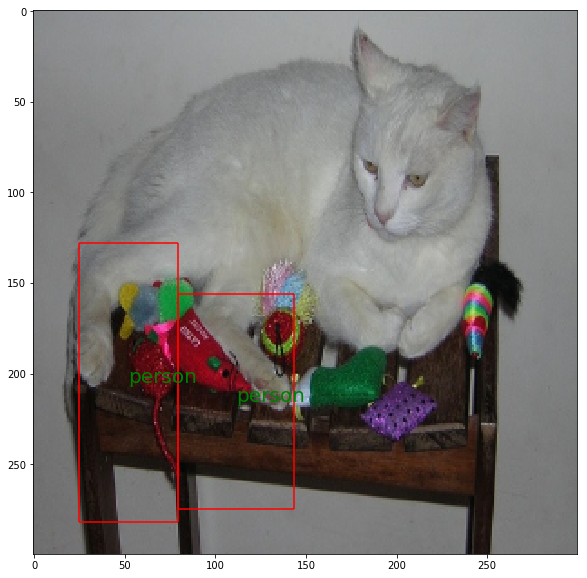

In [29]:
image_path = './VOC2007/test/JPEGImages/000053.jpg'
image = cv2.imread(image_path)
image = image[:,:,::-1]/255
image = cv2.resize(image,(300,300))
image = np.expand_dims(image,axis=0)
[true_boxes,true_classes,true_scores,true_index]  = sess.run([boxes,classes,scores,nms_index],feed_dict={inputs:image,is_training: False})
# [true_boxes,true_classes,true_scores] = sess.run([boxes,classes,scores],feed_dict={inputs:image,is_training: False,keep_prob:1.0})

a = (true_boxes*300)
temp_image = cv2.imread(image_path)
temp_image = temp_image[:,:,::-1]
temp_image = cv2.resize(temp_image,(300,300))
plt.figure(figsize=(10,10))
plt.hlines(a[...,0],a[...,1],a[...,3],colors='red')
plt.hlines(a[...,2],a[...,1],a[...,3],colors='red')
plt.vlines(a[...,1],a[...,0],a[...,2],colors='red')
plt.vlines(a[...,3],a[...,0],a[...,2],colors='red')
for i in range(len(true_classes)):
    position = ((a[i][3]+a[i][1])/2,(a[i][2]+a[i][0])/2)
    plt.text(position[0],position[1],corresponding_dict[true_classes[i]],color='g',size = 20)
plt.imshow(temp_image)
plt.show()

In [21]:
# for single_img in os.listdir('./VOC2007/train/JPEGImages/'):
#     image_path = './VOC2007/train/JPEGImages/'+single_img
#     print(single_img)
#     print(image_path)
#     image = cv2.imread(image_path)
#     image = image[:,:,::-1]/255
#     image = cv2.resize(image,(300,300))
#     image = np.expand_dims(image,axis=0)
#     [true_boxes,true_classes,true_scores] = sess.run([boxes,classes,scores],feed_dict={inputs:image,is_training: False})

#     index = (true_scores>0.5)
#     index_pos = (true_classes!=0)
#     index = np.logical_and(index,index_pos)
#     final_boxes = true_boxes[index]
#     final_classes = true_classes[index]
#     final_scores = true_scores[index]
#     ### nms
#     rclasses,rscores,rboxes = np_methods.bboxes_nms(final_classes, final_scores, final_boxes, nms_threshold=0.5)

#     a = (rboxes*300)
#     temp_image = cv2.imread(image_path)
#     temp_image = temp_image[:,:,::-1]
#     temp_image = cv2.resize(temp_image,(300,300))
#     plt.figure(figsize=(10,10))
#     plt.hlines(a[...,0],a[...,1],a[...,3],colors='red')
#     plt.hlines(a[...,2],a[...,1],a[...,3],colors='red')
#     plt.vlines(a[...,1],a[...,0],a[...,2],colors='red')
#     plt.vlines(a[...,3],a[...,0],a[...,2],colors='red')
#     for i in range(len(rclasses)):
#         position = ((a[i][3]+a[i][1])/2,(a[i][2]+a[i][0])/2)
#         plt.text(position[0],position[1],corresponding_dict[rclasses[i]],color='g',size = 20)
#     plt.imshow(temp_image)
#     plt.show()